In [8]:
df = trips[~trips['DOLocationID'].isin([265]) & ~trips['PULocationID'].isin([265])]
df['do_hour'] = df['dropoff_datetime'].dt.hour
df['pu_hour'] = df['pickup_datetime'].dt.hour
pu = df.groupby(['PULocationID', 'pu_hour']).size().reset_index(name='pu_demand')
do = df.groupby(['DOLocationID', 'do_hour']).size().reset_index(name='do_demand')
flow = pu.merge(do, left_on=['PULocationID', 'pu_hour'], right_on=['DOLocationID', 'do_hour'], how='outer')
flow['net_flow'] = flow['do_demand'].fillna(0) - flow['pu_demand'].fillna(0)
zone_flow = flow.groupby('PULocationID', as_index=False).agg(
    total_pu_demand=('pu_demand', 'sum'),
    total_do_demand=('do_demand', 'sum'),
    net_flow=('net_flow', 'sum')
)

zone_flow = zone_flow.merge(geo[['LocationID', 'latitude', 'longitude']], left_on='PULocationID', right_on='LocationID', how='left')

In [14]:
from sklearn.neighbors import BallTree

zone_coords = np.radians(geo[['latitude', 'longitude']].values)

tree = BallTree(zone_coords, metric='haversine')

radius_km = 3.2 # 2 Meilen ≈ 3.2 km
neighbors = tree.query_radius(zone_coords, r=radius_km / 6371.0088)  # 6371 km = Erdradius

# Erstelle eine Nachbarschaftsmatrix
neighborhood_matrix = pd.DataFrame(0, index=geo['LocationID'], columns=geo['LocationID'])
for i, zone_id in enumerate(geo['LocationID']):
    neighborhood_matrix.loc[zone_id, geo.loc[neighbors[i], 'LocationID']] = 1

In [17]:
from geopy.distance import geodesic

coverage_radius_miles = 1.6 # 1 Meile ≈ 1.6 km

def is_covered(zone_coords, station_coords, radius_miles):
    return geodesic(zone_coords, station_coords).miles <= radius_miles

coverage_matrix = pd.DataFrame(0, index=geo['LocationID'], columns=cs['STATION NA'])
for _, zone in geo.iterrows():
    zone_coords = (zone['latitude'], zone['longitude'])
    for _, station in cs.iterrows():
        station_coords = (station['LATITUDE'], station['LONGITUDE'])
        if is_covered(zone_coords, station_coords, coverage_radius_miles):
            coverage_matrix.loc[zone['LocationID'], station['STATION NA']] = 1

In [7]:
import hdbscan
# Run HDBSCAN with haversine distance
hdb = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=10, metric='haversine')
final_gdf = final_gdf[final_gdf['DOLocationID'] != 265]
final_gdf['cluster'] = hdb.fit_predict(np.radians(coords))
print(final_gdf['cluster'].value_counts())

cluster
-1       83876
 85      75015
 1       22106
 4        4629
 307      1282
         ...  
 2455       10
 583        10
 3764       10
 612        10
 691        10
Name: count, Length: 4049, dtype: int64


C:\Users\r-cet\anaconda3\envs\DSML_env\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


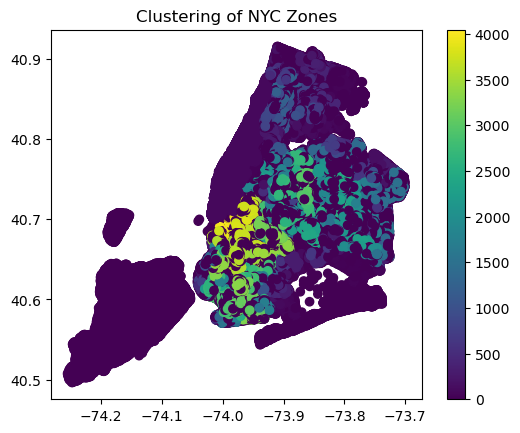

In [10]:
final_gdf.plot(column='cluster', cmap='viridis', legend=True)
plt.title("Clustering of NYC Zones")
plt.show()

In [62]:
import hdbscan
# Run HDBSCAN with haversine distance
hdb = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=5, metric='haversine')
final_gdf = final_gdf[final_gdf['DOLocationID'] != 265]
final_gdf['cluster'] = hdb.fit_predict(np.radians(coords))
print(final_gdf['cluster'].value_counts())

cluster
-1       42345
 2495     2406
 1        1358
 0         742
 236       550
         ...  
 2319        2
 3984        2
 4183        2
 412         2
 567         2
Name: count, Length: 5772, dtype: int64


In [30]:
TOTAL_SAMPLES = 100000  

# Calculate number of samples per group (proportional to original distribution)
group_counts['sample_size'] = (group_counts['proportion'] * TOTAL_SAMPLES).astype(int)

# Ensure minimum of 1 sample per group
group_counts['sample_size'] = group_counts['sample_size'].clip(lower=1)


In [31]:
def stratified_sampling(group):
    """Sample each group based on precomputed sample sizes"""
    n = group_counts.loc[
        (group_counts['dropoff_hour'] == group.name[0]) & 
        (group_counts['DOLocationID'] == group.name[1]), 
        'sample_size'
    ].values[0]
    return group.sample(n=min(n, len(group)), random_state=42)

# Apply sampling per (dropoff_hour, DOLocationID) group
sampled_df = cl.groupby(['dropoff_hour', 'DOLocationID'], group_keys=False).apply(stratified_sampling)

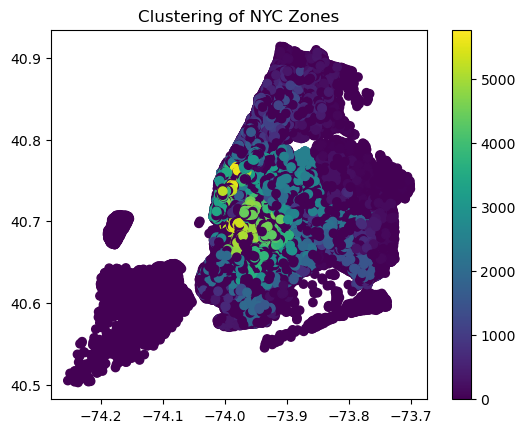

In [63]:
final_gdf.plot(column='cluster', cmap='viridis', legend=True)
plt.title("Clustering of NYC Zones")
plt.show()

In [34]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97406 entries, 4364074 to 2246964
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   request_datetime  97406 non-null  datetime64[ns]
 1   pickup_datetime   97406 non-null  datetime64[ns]
 2   dropoff_datetime  97406 non-null  datetime64[ns]
 3   PULocationID      97406 non-null  int32         
 4   DOLocationID      97406 non-null  int32         
 5   trip_miles        97406 non-null  float64       
 6   trip_time         97406 non-null  int64         
 7   dropoff_hour      97406 non-null  int32         
dtypes: datetime64[ns](3), float64(1), int32(3), int64(1)
memory usage: 5.6 MB


In [57]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
eps_km = 0.1
eps_rad = eps_km / 6371.0088
coords_rad = np.radians(coords)
dbscan = DBSCAN(eps=eps_rad, min_samples=4, metric='haversine')
final_gdf['cluster'] = dbscan.fit_predict(coords_rad)
print(final_gdf['cluster'].value_counts())

cluster
 4       35548
 19      18321
-1       11001
 20       6043
 5        2539
         ...  
 1644        2
 1643        2
 1408        2
 1544        2
 1634        2
Name: count, Length: 1696, dtype: int64


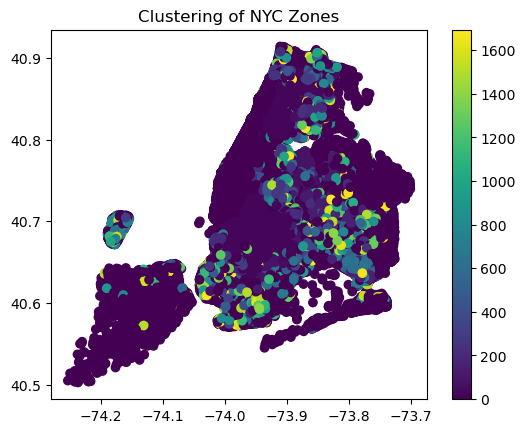

In [58]:
final_gdf.plot(column='cluster', cmap='viridis', legend=True)
plt.title("Clustering of NYC Zones")
plt.show()